In [4]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from tensorflow_probability.python.math.psd_kernels.internal import util
from typing import List


# Configure plot defaults
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["grid.color"] = "#666666"

In [1]:
cd ..

/Users/jibanmac/Documents/GitHub/multi_fidelity_tensorflow


In [23]:
from multi_fidelity_tensorflow.data_loader import StellarMassFunctions, PowerSpecs

In [5]:
np.random.seed(20)

# Multi-Fidelity GP using Two GPs using tensorflow

Use the multi-fidelity example in the emukit


In [6]:
data = StellarMassFunctions(
    folder="../camels_resolution/data/illustris-5-8/1004_LR_7_HR_test2/"
)

In [157]:
data = PowerSpecs(
    folder="../matter_emu_dgmgp/data/processed/Matterpower_60_res128box256_3_res512box256_z0_ind-0-1-2/"
)

In [158]:
# original code
#  https://github.com/EmuKit/emukit/blob/main/emukit/test_functions/forrester.py


def forrester(x, sd=0):
    """
    Forrester function
    :param x: input vector to be evaluated
    :param sd: standard deviation of noise parameter
    :return: outputs of the function
    """
    x = x.reshape((len(x), 1))
    n = x.shape[0]
    fval = ((6 * x - 2) ** 2) * np.sin(12 * x - 4)
    if sd == 0:
        noise = np.zeros(n).reshape(n, 1)
    else:
        noise = np.random.normal(0, sd, n).reshape(n, 1)
    return fval.reshape(n, 1) + noise


def forrester_low(x, sd=0):
    """
    Low fidelity forrester function approximation:
    :param x: input vector to be evaluated
    :param sd: standard deviation of observation noise at low fidelity
    :return: outputs of the function
    """
    high_fidelity = forrester(x, 0)
    return (
        0.5 * high_fidelity
        + 10 * (x[:, [0]] - 0.5)
        + 5
        + np.random.randn(x.shape[0], 1) * sd
    )

In [159]:
high_fidelity = forrester
low_fidelity = forrester_low

x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

x_train_l = np.atleast_2d(np.random.rand(40)).T
x_train_h = np.atleast_2d(np.random.permutation(x_train_l)[:6])
y_train_l = low_fidelity(x_train_l)
y_train_h = high_fidelity(x_train_h)

In [160]:
x_train_l.shape, x_train_h.shape, y_train_l.shape, y_train_h.shape

((40, 1), (6, 1), (40, 1), (6, 1))

In [161]:
data.X_train[0].shape, data.X_train[1].shape, data.Y_train_norm[
    0
].shape, data.Y_train_norm[1].shape

((60, 5), (3, 5), (60, 96), (3, 96))

In [162]:
# convert MF data to coregional data :
# X = [(Xlf, 0) (Xhf, 1)]
# Y = [Ylf       Yhf]

# append 0
fidelity = 0
_Xlf = np.concatenate([
    data.X_train_norm[fidelity],
    np.ones((data.X_train_norm[fidelity].shape[0], 1)) * fidelity,
], axis=1)
# append 1
fidelity = 1
_Xhf = np.concatenate([
    data.X_train_norm[fidelity],
    np.ones((data.X_train_norm[fidelity].shape[0], 1)) * fidelity,
], axis=1)


X = np.concatenate([
    _Xlf, _Xhf
], axis=0)
Y = np.concatenate([
    data.Y_train_norm[0], data.Y_train_norm[1]
], axis=0)

X.shape, Y.shape

((63, 6), (63, 96))

In [164]:
X

array([[0.15833333, 0.59166667, 0.14166667, 0.55833333, 0.95833333,
        0.        ],
       [0.45833333, 0.075     , 0.375     , 0.325     , 0.125     ,
        0.        ],
       [0.825     , 0.89166667, 0.90833333, 0.75833333, 0.49166667,
        0.        ],
       [0.19166667, 0.75833333, 0.50833333, 0.90833333, 0.30833333,
        0.        ],
       [0.525     , 0.65833333, 0.175     , 0.19166667, 0.975     ,
        0.        ],
       [0.74166667, 0.05833333, 0.725     , 0.375     , 0.40833333,
        0.        ],
       [0.24166667, 0.625     , 0.99166667, 0.85833333, 0.24166667,
        0.        ],
       [0.625     , 0.025     , 0.225     , 0.59166667, 0.54166667,
        0.        ],
       [0.775     , 0.85833333, 0.60833333, 0.025     , 0.69166667,
        0.        ],
       [0.325     , 0.55833333, 0.55833333, 0.10833333, 0.00833333,
        0.        ],
       [0.44166667, 0.00833333, 0.80833333, 0.775     , 0.64166667,
        0.        ],
       [0.85833333, 0

More HF training points than the LF training points.

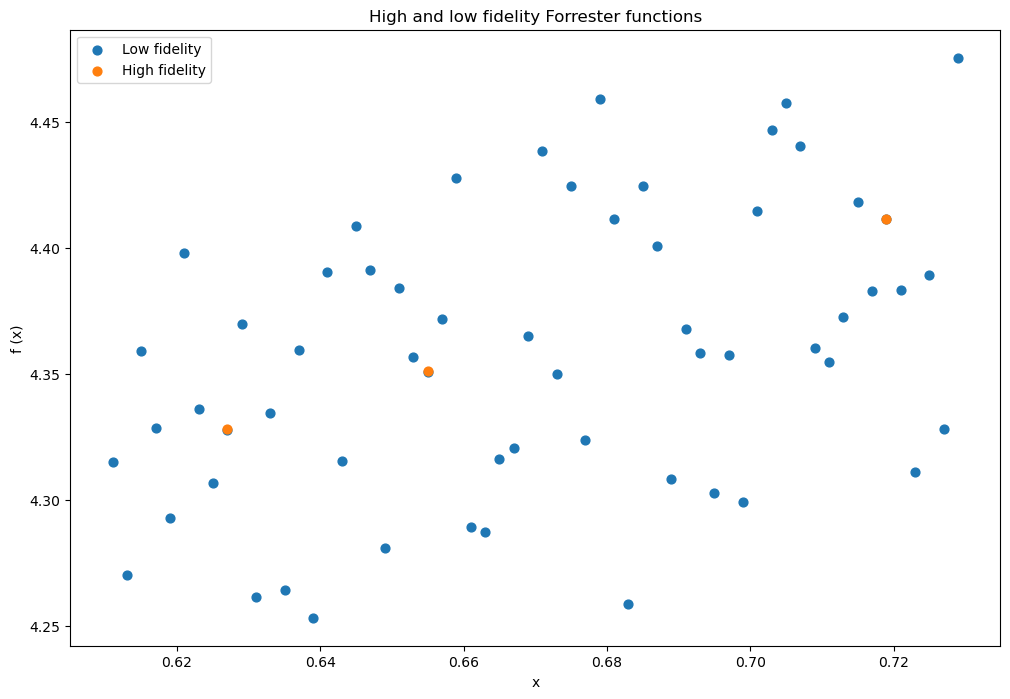

In [163]:
## Plot the original functions
plt.figure(figsize=(12, 8))
plt.scatter(data.X_train[0][:, 2], data.Y_train[0][:, 0], color="C0", s=40)
plt.scatter(data.X_train[1][:, 2], data.Y_train[1][:, 0], color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["Low fidelity", "High fidelity"])
plt.title("High and low fidelity Forrester functions");

## Multi-fidelity with Linear scale kernel

We could define a new kernel class to incorporate two kernels

In [198]:
X.shape

(63, 6)

In [217]:
class LinearMultiFidelityKernel(tfk.PositiveSemidefiniteKernel):

    """
        Fidelity s is modelled as:
        f_s(x) = p_t * f_t(x) + d_s(x)

        where:
        s is the fidelity
        t is the previous fidelity
        f_s(x) is the function modelling fidelity s
        d_s(x) models the difference between fidelity s-1 and s
        p_t a scaling parameter between fidelity t and s

    TODO: Now only assume two fidelities, so

        Fidelity s is modelled as:
        f_2(x) = p_1 * f_1(x) + d_2(x)

    """

    def __init__(
        self,
        kernel_list: List,
        scale_parameter_list: List,
        name="LinearMultiFidelityKernel",
    ):
        # Now only assume two fidelities
        # TODO: this part needs update to more fidelities. Though in general I think
        #       it is not quite useful in the scale of n_fidelities > 2 unless it is
        #       marginalizing over fidelities.
        self._kernel_0 = kernel_list[0]  # HF
        self._kernel_1 = kernel_list[1]  # LF
        # for the batch_shape, use the HF kernel
        self._kernel = kernel_list[0]

        self._scale_parameter = scale_parameter_list[0]

        super(LinearMultiFidelityKernel, self).__init__(
            feature_ndims=self._kernel.feature_ndims,
            dtype=self._kernel.dtype,
            name=name,
        )

    def _apply(self, x1, x2, example_ndims=0):
        # import pdb
        # pdb.set_trace()

        # here is just broadcasting this rho to all batches
        # in principle you might make it to be batch dependent
        # (so that different scale for different outputs, in case
        # of vector outputs)
        rho = self._scale_parameter

        rho = tf.convert_to_tensor(rho)
        rho = util.pad_shape_with_ones(rho, example_ndims)


        ind_11 = tf.where(x1[:, 0, -1] == np.float64(0))
        ind_21 = tf.where(x2[0, :, -1] == np.float64(0))
        ind_12 = tf.where(x1[:, 0, -1] == np.float64(1))
        ind_22 = tf.where(x2[0, :, -1] == np.float64(1))

        # total covariance
        K = tf.zeros((x1.shape[0], x2.shape[1]))

        # K11
        k_lf_11 = self._kernel_1.apply(
            x1[ind_11, :, :-1], x2[:, ind_21, :-1], example_ndims
        )  # otherwise the passing batches won't work
        K[ind_11, ind_21] = k_lf_11

        # K21
        k_lf_21 = self._kernel_1.apply(
            x1[ind_12, :, :-1], x2[:, ind_21, :-1], example_ndims
        )  # otherwise the passing batches won't work
        K[ind_12, ind_21] = k_lf_21 * rho

        # K12
        k_lf_12 = self._kernel_1.apply(
            x1[ind_11, :, :-1], x2[:, ind_22, :-1], example_ndims
        )  # otherwise the passing batches won't work
        K[ind_11, ind_22] = k_lf_12 * rho

        # K22
        k_lf_22 = self._kernel_1.apply(
            x1[ind_12, :, :-1], x2[:, ind_22, :-1], example_ndims
        )  # otherwise the passing batches won't work
        k_hf = self._kernel_0.apply(
            x1[ind_12, :, :-1], x2[:, ind_22, :-1], example_ndims
        )  # important!! Need to pass example_ndims

        K[ind_12, ind_22] = k_lf_22 * rho + k_hf

        # x1 : (9, 1, 5)
        # x2 : (1, 9, 5)
        # k_hf : (96, 9, 9)
        # rho : (96, 1, 1)
        return K

    @property
    def batch_shape(self):
        return self._kernel.batch_shape

    def batch_shape_tensor(self):
        return self._kernel.batch_shape_tensor

My design here is to build two GPs, while the HF one is coupled with the LF one. The learnable parameters are shared between the GPs. The scale parameter for the correlation should be placed in the kernel.

```

1st GP:
---
X_LF -> GP_LF -> Y_LF

2nd GP:
---
X_HF -> GP_LF -> f_LF  
X_HF -> GP_HF -> delta_HF  
              -> f_LF * rho + delta_HF
```

In [218]:
X_lf = data.X_train_norm[0]
X_hf = data.X_train_norm[1]

Y_lf = data.Y_train_norm[0].T
Y_hf = data.Y_train_norm[1].T

num_examples_lf, num_features = X_lf.shape
num_examples_hf, num_features = X_hf.shape
num_outputs, num_examples_lf = Y_lf.shape
num_outputs, num_examples_hf = Y_hf.shape

X_lf.shape, Y_lf.shape, X_hf.shape, Y_hf.shape,

((60, 5), (96, 60), (3, 5), (96, 3))

In [219]:
def build_gp_lf(amplitude, length_scales, observation_noise_variance):
    """
    Low-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    X_LF -> GP_LF -> Y_LF

    """
    # choose your kernel. Not define lengthscale, fall back to lengthscale = 1
    se_kernel = tfk.ExponentiatedQuadratic(amplitude)
    # this is our ARD kernel, with 1 lengthscale per feature dim.
    # we use scale_diag to represent the lengthscales.
    kernel = tfk.FeatureScaled(
        se_kernel,
        scale_diag=length_scales,
    )
    # Exercise: why applying FeatureScaled makes the ExponentiatedQuadratic to be ARD?

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=X_lf,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance,
    )


def build_gp_hf(
    amplitude_0,  # HF
    length_scale_0,  # HF
    amplitude_1,  # LF
    length_scale_1,  # LF
    observation_noise_variance,
    scale_parameter,
):
    """
    High-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    f_HF = \rho f_LF + \delta

      X_HF -> GP_LF -> f_LF
      X_HF -> GP_HF -> delta_HF
                  -> f_LF * rho + delta_HF
    """

    # HF kernel
    se_kernel_0 = tfk.ExponentiatedQuadratic(amplitude_0)
    kernel_0 = tfk.FeatureScaled(
        se_kernel_0,
        scale_diag=length_scale_0,
    )
    # LF kernel
    se_kernel_1 = tfk.ExponentiatedQuadratic(amplitude_1,)
    kernel_1 = tfk.FeatureScaled(
        se_kernel_1,
        scale_diag=length_scale_1,
    )

    ar1_kernel = LinearMultiFidelityKernel(
        [kernel_0, kernel_1], [scale_parameter], name="AR1"
    )

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=ar1_kernel,
        index_points=X,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance,
    )


gp_joint_model_lf = tfd.JointDistributionNamed(
    {
        'amplitude':
            tfd.LogNormal(
                loc=np.ones([num_outputs]) * 0,
                scale=np.ones([num_outputs]) * 0.5              # roughly move lengthscale to center around 1
        ),
        "length_scales":
            tfd.Independent(
                tfd.LogNormal(
                    loc=np.ones([num_outputs, num_features]),
                    scale=np.ones(
                        [num_outputs, num_features]
                    ),  # roughly move lengthscale to center around 1
                ),
                reinterpreted_batch_ndims=1,
            ),
        "observation_noise_variance": tfd.LogNormal(
            loc=np.ones([num_outputs]) * 0.0, scale=np.ones([num_outputs]) 
        ),
        "observations": build_gp_lf,
    }
)

gp_joint_model_hf = tfd.JointDistributionNamed(
    {
        "amplitude_0": tfd.LogNormal(
                loc=np.ones([num_outputs]) * 0,
                scale=np.ones([num_outputs])
        ),
        "length_scale_0": tfd.Independent(
                tfd.LogNormal(
                    loc=np.ones([num_outputs, num_features]),
                    scale=np.ones(
                        [num_outputs, num_features]
                    ),  # roughly move lengthscale to center around 1
                ),
                reinterpreted_batch_ndims=1,
            ),
        "amplitude_1": tfd.LogNormal(
                loc=np.ones([num_outputs]) * 0,
                scale=np.ones([num_outputs])
        ),
        "length_scale_1": tfd.Independent(
                tfd.LogNormal(
                    loc=np.ones([num_outputs, num_features]),
                    scale=np.ones(
                        [num_outputs, num_features]
                    ),  # roughly move lengthscale to center around 1
                ),
                reinterpreted_batch_ndims=1,
            ),
        "scale_parameter": tfd.LogNormal(
            loc=np.ones([num_outputs]) * 0.0, scale=np.ones([num_outputs]),
        ),
        "observation_noise_variance": tfd.LogNormal(
            loc=np.ones([num_outputs]) * 0.0, scale=np.ones([num_outputs]) 
        ),
        "observations": build_gp_hf,
    }
)

In [220]:
X.shape

(63, 6)

In [221]:
# Test the batch shape
gp_joint_model_lf.batch_shape

{'observation_noise_variance': TensorShape([96]),
 'length_scales': TensorShape([96]),
 'amplitude': TensorShape([96]),
 'observations': TensorShape([96])}

In [222]:
gp_joint_model_hf.batch_shape

ValueError: Shapes must be equal rank, but are 2 and 0
	From merging shape 0 with other shapes. for '{{node GaussianProcess/sample/GaussianProcess/get_marginal_distribution/AR1/matrix/strided_slice_4/stack_1}} = Pack[N=3, T=DT_INT64, axis=0](GaussianProcess/sample/GaussianProcess/get_marginal_distribution/AR1/matrix/Where, GaussianProcess/sample/GaussianProcess/get_marginal_distribution/AR1/matrix/strided_slice_4/stack_1/values_1, GaussianProcess/sample/GaussianProcess/get_marginal_distribution/AR1/matrix/strided_slice_4/stack_1/values_2)' with input shapes: [?,1], [], [].

Let's test if we can compute the log prob


In [137]:
x_l = gp_joint_model_lf.sample()
lp_l = gp_joint_model_lf.log_prob(x_l)

print("sampled {}".format(x_l))
print("log_prob of sample: {}".format(lp_l))

sampled {'observation_noise_variance': <tf.Tensor: shape=(96,), dtype=float64, numpy=
array([ 0.18567241,  0.31545368,  0.41846123,  2.2021754 ,  3.5650124 ,
        1.25275297,  0.95404969,  0.8247539 ,  1.35643431,  0.73420972,
        0.05751317,  0.47192784,  0.13376671,  1.77331331,  0.69077825,
        1.78294683,  3.58656578,  1.66918601,  2.17053771,  1.8708011 ,
        0.22777899,  0.38350241,  0.81748118,  1.73722829,  0.76037739,
        5.3172744 ,  1.81885488, 11.61269609,  0.04391607,  2.41298983,
        5.02359206,  1.01774595,  0.91490264,  0.67568151,  1.47327139,
        3.20547952,  2.12899158,  2.90310371,  1.28724139,  0.42339393,
        0.33242485,  2.00503314,  3.25411538,  4.65322372,  0.62873517,
        0.41054162, 13.47304067,  0.8400389 ,  0.44985139,  5.11331608,
        0.60459571,  0.66551333,  3.76601131,  3.2724941 ,  0.58056256,
        4.30047799,  1.96028725,  0.90400831,  1.72014964,  1.16028714,
        0.75995931,  2.62152047,  0.44579359,  0.8

In [138]:
x_h = gp_joint_model_hf.sample()
lp_h = gp_joint_model_hf.log_prob(x_h)

print("sampled {}".format(x_h))
print("log_prob of sample: {}".format(lp_h))

sampled {'scale_parameter': <tf.Tensor: shape=(96,), dtype=float64, numpy=
array([ 0.43792968,  0.60129286,  1.32879319,  0.25791547,  1.50733811,
        0.57135544,  1.11877714,  1.36698218,  0.21710749,  2.66287907,
        0.33766653,  2.0811449 ,  0.92935107,  4.64650301,  0.34743091,
        1.60372373,  0.1749802 ,  0.80838001,  0.47170572,  0.74782221,
        1.01029278,  0.26922344,  0.99913785,  0.88421472,  0.47311103,
        1.12984281,  3.88496605,  0.44909508,  1.18510734,  2.4940012 ,
        2.33829249,  1.36598825, 12.22987745,  0.16498617,  1.53853947,
        2.64154246,  0.72150617,  2.19932025,  1.39687458,  0.52028987,
        3.2314922 ,  1.14403019,  2.02813196,  2.50720414,  0.56799216,
        1.62679033,  3.1339272 ,  1.21139996,  0.10850283,  0.1035425 ,
        2.91703704,  1.4669101 ,  0.44493758,  0.57242359,  0.62413515,
        0.32076091,  1.88693924,  1.17081949,  8.77821519,  2.5664247 ,
        0.25065947,  1.16284933,  1.7473531 ,  0.83035811,  0

Set the learnable parameters and train based on the maximum marginal likelihoods of two GPs.

In [139]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.
# jibancat: the scale parameter no needs to be positive,
# but I guess it's okay to constrain it to be positive so the delta would
# compensate the sign difference.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs]),
    bijector=constrain_positive,
    name='amplitude_0',
    dtype=np.float64)

length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs, num_features]),
    bijector=constrain_positive,
    name='length_scale_0',
    dtype=np.float64)

observation_noise_variance_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs]) * 0.05,
    bijector=constrain_positive,
    name='observation_noise_variance_var_0',
    dtype=np.float64)


amplitude_var_1 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs]),
    bijector=constrain_positive,
    name='amplitude_1',
    dtype=np.float64)

length_scale_var_1 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs, num_features]),
    bijector=constrain_positive,
    name='length_scale_1',
    dtype=np.float64)

observation_noise_variance_var_1 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs]) * 0.05,
    bijector=constrain_positive,
    name='observation_noise_variance_var_1',
    dtype=np.float64)

scale_parameter_var = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs]),
    bijector=constrain_positive,
    name='scale_parameter_var',
    dtype=np.float64)

trainable_variables = [
    v.trainable_variables[0]
    for v in [
        amplitude_var_0,
        length_scale_var_0,
        observation_noise_variance_var_0,
        amplitude_var_1,
        length_scale_var_1,
        observation_noise_variance_var_1,
        scale_parameter_var,
    ]
]

To condition the model on our observed data, we'll define a `target_log_prob` function, which takes the (still to be inferred) kernel hyperparameters.

We will combine the log likelihoods from both GP_LF and GP_HF to be one joint likelihood.

In [140]:
y_train_l.shape, Y_lf.shape

((40, 1), (96, 60))

In [141]:
def target_log_prob(
    amplitude_0,
    length_scale_0,
    observation_noise_variance_0,
    amplitude_1,
    length_scale_1,
    observation_noise_variance_1,
    scale_parameter,
):
    """
    Loglike(LF) + Loglike(HF)
    """

    log_prob_lf = gp_joint_model_lf.log_prob(
        {
            "amplitude": amplitude_1,
            "length_scales": length_scale_1,
            "observation_noise_variance": observation_noise_variance_1,
            "observations": Y_lf,
        }
    )

    log_prob_hf = gp_joint_model_hf.log_prob(
        {
            "amplitude_0": amplitude_0,
            "length_scale_0": length_scale_0,
            "amplitude_1": amplitude_1,
            "length_scale_1": length_scale_1,
            "observation_noise_variance": observation_noise_variance_0,
            "observations": Y_hf,
            "scale_parameter": scale_parameter,
        }
    )

    return tf.reduce_sum([log_prob_hf, log_prob_lf])

In [142]:
target_log_prob(
            amplitude_0=amplitude_var_0,
            length_scale_0=length_scale_var_0,
            amplitude_1=amplitude_var_1,
            length_scale_1=length_scale_var_1,
            observation_noise_variance_0=observation_noise_variance_var_0,
            observation_noise_variance_1=observation_noise_variance_var_1,
            scale_parameter=scale_parameter_var,
        )

<tf.Tensor: shape=(), dtype=float64, numpy=-3012.491895155962>

In [143]:
# Now we optimize the model parameters.
num_iters = 10000
optimizer = tf.optimizers.Adam(learning_rate=1e-2)


# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
    with tf.GradientTape() as tape:
        loss = -target_log_prob(
            amplitude_0=amplitude_var_0,
            length_scale_0=length_scale_var_0,
            amplitude_1=amplitude_var_1,
            length_scale_1=length_scale_var_1,
            observation_noise_variance_0=observation_noise_variance_var_0,
            observation_noise_variance_1=observation_noise_variance_var_1,
            scale_parameter=scale_parameter_var,
        )
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss


# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model()
    lls_[i] = loss

print("Trained parameters:")
print("Scale parameter:", scale_parameter_var)
print("LF amplitude: {}".format(amplitude_var_1._value().numpy()))
print("LF length_scale: {}".format(length_scale_var_1._value().numpy()))
print(
    "LF observation_noise_variance: {}".format(
        observation_noise_variance_var_1._value().numpy()
    )
)
print("HF amplitude: {}".format(amplitude_var_0._value().numpy()))
print("HF length_scale: {}".format(length_scale_var_0._value().numpy()))
print(
    "HF observation_noise_variance: {}".format(
        observation_noise_variance_var_0._value().numpy()
    )
)

Trained parameters:
Scale parameter: <TransformedVariable: name=scale_parameter_var, dtype=float64, shape=[96], fn="chain_of_shift_of_exp", numpy=
array([0.37133114, 0.37597837, 0.38111878, 0.38299917, 0.38256766,
       0.38440291, 0.38538015, 0.39023324, 0.39323851, 0.39171902,
       0.39085458, 0.39149129, 0.39451172, 0.39683852, 0.39981862,
       0.40035447, 0.39868476, 0.40013638, 0.40147852, 0.40679096,
       0.40777159, 0.40588875, 0.40884981, 0.41416918, 0.41572014,
       0.41651682, 0.42057326, 0.4232927 , 0.42589591, 0.43045728,
       0.42904356, 0.42715087, 0.42937209, 0.43757736, 0.43160525,
       0.44121825, 0.43498106, 0.43753256, 0.44710796, 0.45463532,
       0.45764436, 0.46147919, 0.45513668, 0.44965869, 0.44593878,
       0.45554859, 0.47739323, 0.4493087 , 0.45924723, 0.4397241 ,
       0.44131185, 0.43931592, 0.44491688, 0.43893058, 0.42818563,
       0.42501108, 0.42412313, 0.42063609, 0.41543531, 0.42347496,
       0.42245243, 0.4255614 , 0.42485764, 0.4357

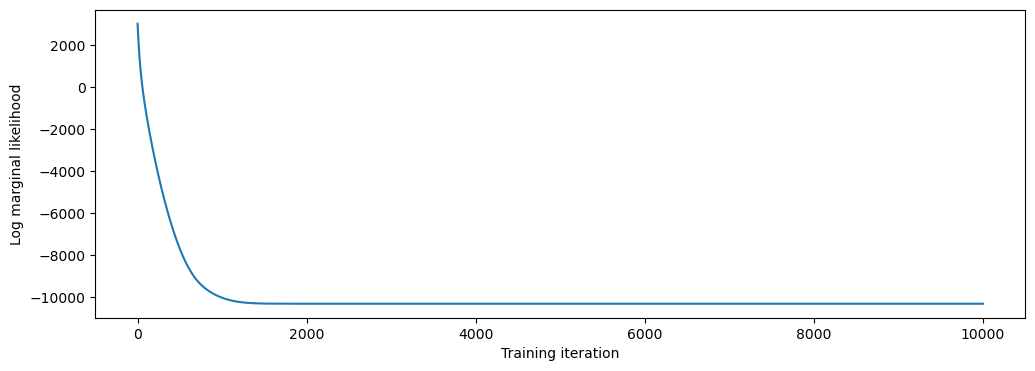

In [144]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [145]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.

# Test input cosmologies
predictive_index_points_ = data.X_test_norm[0]

# HF kernel
optimized_se_kernel_0 = tfk.ExponentiatedQuadratic(amplitude_var_0)
optimized_kernel_0 = tfk.FeatureScaled(
    optimized_se_kernel_0,
    scale_diag=length_scale_var_0,
)
# LF kernel
optimized_se_kernel_1 = tfk.ExponentiatedQuadratic(amplitude_var_1,)
optimized_kernel_1 = tfk.FeatureScaled(
    optimized_se_kernel_1,
    scale_diag=length_scale_var_1,
)

optimized_ar1_kernel = LinearMultiFidelityKernel(
    [optimized_kernel_0, optimized_kernel_1], [scale_parameter_var], name="AR1"
)

# Create the GP prior distribution, which we will use to train the model
# parameters.
ar1_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_ar1_kernel,
    index_points=predictive_index_points_,
    observation_index_points=X_hf,
    observations=Y_hf,
    observation_noise_variance=observation_noise_variance_var_0,
    predictive_noise_variance=np.float64(0.0),
)


# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 100
samples = ar1_gprm.sample(num_samples)


h_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_0,
    index_points=predictive_index_points_,
    observation_index_points=X_hf,
    observations=Y_hf,
    observation_noise_variance=observation_noise_variance_var_0,
    predictive_noise_variance=np.float64(0.0),
)

h_samples = h_gprm.sample(num_samples)

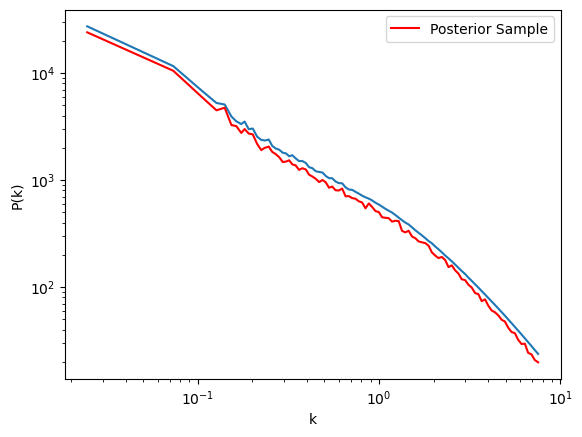

In [146]:
# plot the Pk comparison: GP predictions versus true Pk
test_i = 6

plt.loglog(10**data.kf, 10**(data.Y_test[0][test_i, :]))

# for i in range(num_samples):
#     plt.loglog(10**data.kf, 10**(samples[i, :, test_i]),
#         c='r', alpha=.1,
#         label='Posterior Sample' if i == 0 else None
#     )

plt.loglog(10**data.kf, 10**(samples[:, :, test_i].numpy().mean(0)),
    c='r',
    label='Posterior Sample'
)


leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"k")
plt.ylabel("P(k)")
plt.show()

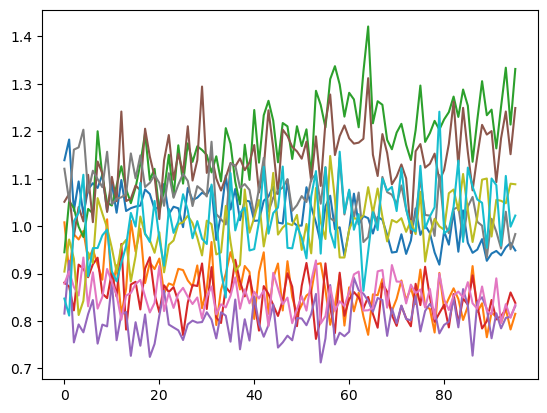

In [147]:
pred_exact = 10**(samples.numpy().mean(axis=0)) / 10**(
    data.Y_test[0].T
)
plt.plot(pred_exact);

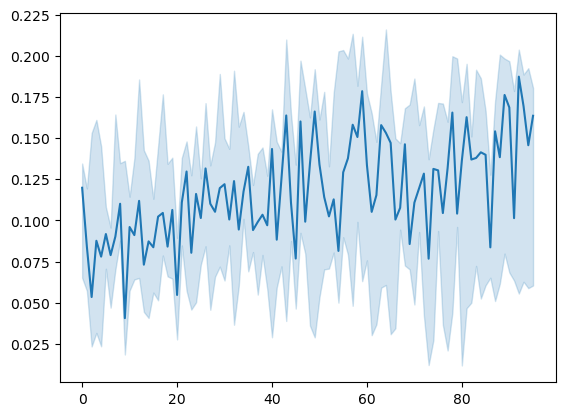

In [148]:
lower_error, median_error, upper_error = np.quantile(np.abs(pred_exact - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error)
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

# jibancat save the variable for later use
_pred_exact_map = pred_exact

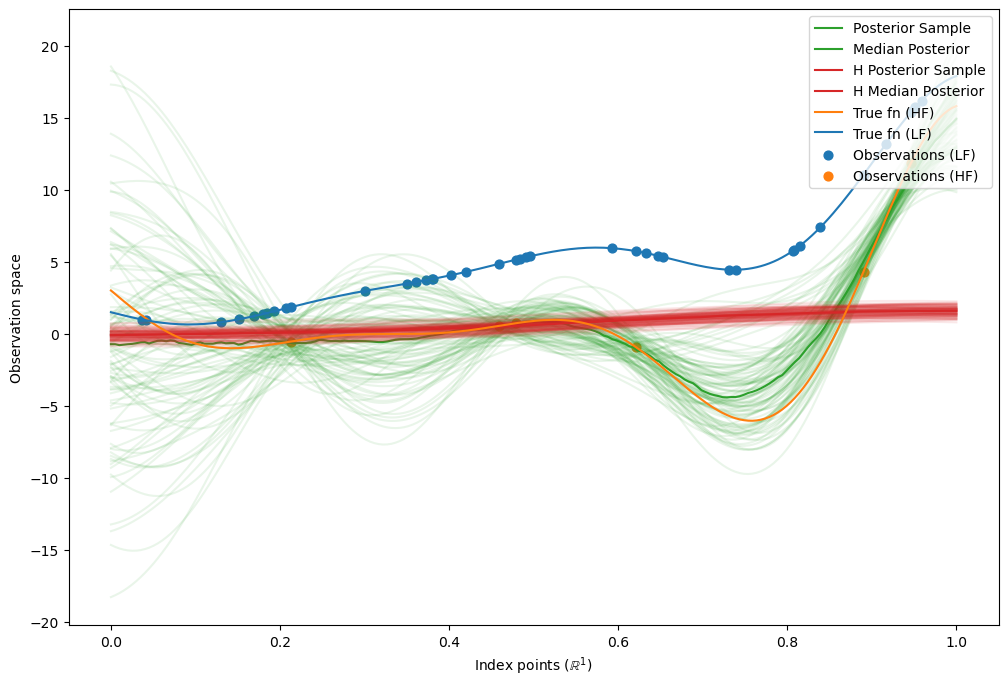

In [19]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 8))

# AR1
for i in range(num_samples):
    plt.plot(
        predictive_index_points_,
        samples[i, :],
        c="C2",
        alpha=0.1,
        label="Posterior Sample" if i == 0 else None,
    )

plt.plot(
    predictive_index_points_,
    np.median(samples, axis=0),
    c="C2",
    label="Median Posterior",
)

# HF
for i in range(num_samples):
    plt.plot(
        predictive_index_points_,
        h_samples[i, :],
        c="C3",
        alpha=0.1,
        label="H Posterior Sample" if i == 0 else None,
    )

plt.plot(
    predictive_index_points_,
    np.median(h_samples, axis=0),
    c="C3",
    label="H Median Posterior",
)

plt.plot(x_plot, y_plot_h, label="True fn (HF)", color="C1")
plt.plot(x_plot, y_plot_l, label="True fn (LF)", color="C0")

plt.scatter(x_train_l, y_train_l, color="C0", s=40, label="Observations (LF)")
plt.scatter(x_train_h, y_train_h, color="C1", s=40, label="Observations (HF)")


leg = plt.legend(loc="upper right")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

If you only train on HF data:

In [20]:
def build_gp(amplitude, length_scale, observation_noise_variance):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=x_train_h,
        observation_noise_variance=observation_noise_variance,
    )


gp_joint_model = tfd.JointDistributionNamed(
    {
        "amplitude": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "length_scale": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observation_noise_variance": tfd.LogNormal(loc=0.0, scale=np.float64(0.025)),
        "observations": build_gp,
    }
)

# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, name="amplitude", dtype=np.float64
)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="length_scale",
    dtype=np.float64,
)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="observation_noise_variance_var",
    dtype=np.float64,
)

trainable_variables_hf_only = [
    v.trainable_variables[0]
    for v in [amplitude_var, length_scale_var, observation_noise_variance_var]
]


def target_log_prob_hf_only(amplitude, length_scale, observation_noise_variance):
    return gp_joint_model.log_prob(
        {
            "amplitude": amplitude,
            "length_scale": length_scale,
            "observation_noise_variance": observation_noise_variance,
            "observations": y_train_h[:, 0],
        }
    )


# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=0.01)


# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
    with tf.GradientTape() as tape:
        loss = -target_log_prob_hf_only(
            amplitude_var, length_scale_var, observation_noise_variance_var
        )
    grads = tape.gradient(loss, trainable_variables_hf_only)
    optimizer.apply_gradients(zip(grads, trainable_variables_hf_only))
    return loss


# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model()
    lls_[i] = loss


# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.

# HF only kernel
optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)

h_only_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=x_train_h,
    observations=y_train_h[:, 0],
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=np.float64(0.0),
)

h_only_samples = h_only_gprm.sample(num_samples)

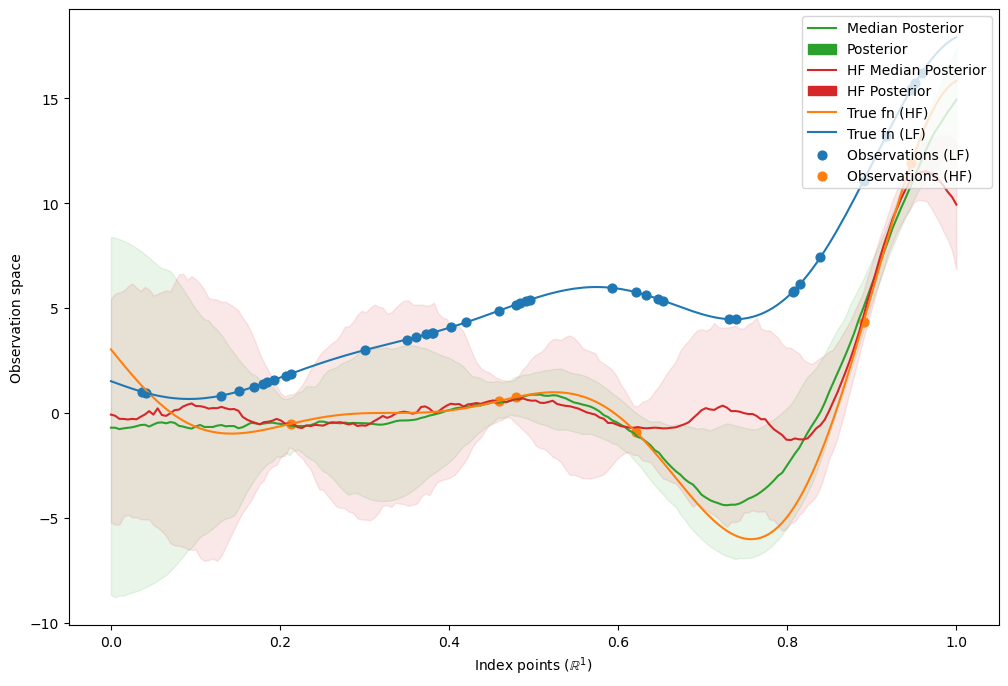

In [21]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 8))

lower, median, upper = np.quantile(samples.numpy(), [0.1, 0.5, 0.9], axis=0)

# AR1
plt.plot(predictive_index_points_, median, c="C2", label="Median Posterior")
plt.fill_between(
    predictive_index_points_[:, 0],
    lower,
    upper,
    color="C2",
    alpha=0.1,
    label="Posterior",
)


lower_hf, median_hf, upper_hf = np.quantile(
    h_only_samples.numpy(), [0.1, 0.5, 0.9], axis=0
)

# HF
plt.plot(predictive_index_points_, median_hf, c="C3", label="HF Median Posterior")
plt.fill_between(
    predictive_index_points_[:, 0],
    lower_hf,
    upper_hf,
    color="C3",
    alpha=0.1,
    label="HF Posterior",
)

plt.plot(x_plot, y_plot_h, label="True fn (HF)", color="C1")
plt.plot(x_plot, y_plot_l, label="True fn (LF)", color="C0")

plt.scatter(x_train_l, y_train_l, color="C0", s=40, label="Observations (LF)")
plt.scatter(x_train_h, y_train_h, color="C1", s=40, label="Observations (HF)")


leg = plt.legend(loc="upper right")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

## Marginalizing hyperparameters with HMC

Instead of optimizing the hyperparameters, let's try integrating them out with Hamiltonian Monte Carlo. We'll first define and run a sampler to approximately draw from the posterior distribution over kernel hyperparameters, given the observations.

In [22]:
num_results = 150
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob, step_size=tf.cast(0.1, tf.float64)
    ),
    bijector=[
        constrain_positive,
        constrain_positive,
        constrain_positive,
        constrain_positive,
        constrain_positive,
        constrain_positive,
        constrain_positive,
    ],
)

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64),
)

initial_state = [tf.cast(x, tf.float64) for x in [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

In [23]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
    return tfp.mcmc.sample_chain(
        kernel=adaptive_sampler,
        current_state=initial_state,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda current_state, kernel_results: kernel_results,
    )


t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1 - t0))

Inference ran in 7.46s.


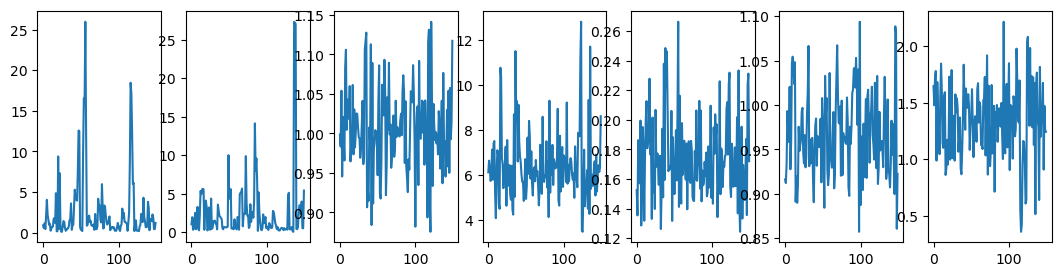

In [24]:
(
    amplitude_0_samples,
    length_scale_0_samples,
    observation_noise_variance_0_samples,
    amplitude_1_samples,
    length_scale_1_samples,
    observation_noise_variance_1_samples,
    scale_parameter_samples,
) = samples

f = plt.figure(figsize=[15, 3])
for i, s in enumerate(samples):
    ax = f.add_subplot(1, len(samples) + 1, i + 1)
    ax.plot(s)

In [25]:
# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.

# HF kernel
batch_kernel_0 = tfk.ExponentiatedQuadratic(
    amplitude_0_samples,
    length_scale_0_samples,
)
# LF kernel
batch_kernel_1 = tfk.ExponentiatedQuadratic(
    amplitude_1_samples,
    length_scale_1_samples,
)

batch_ar1_kernel = LinearMultiFidelityKernel(
    [batch_kernel_0, batch_kernel_1], [scale_parameter_samples], name="AR1"
)

# Create the GP prior distribution, which we will use to train the model
# parameters.
batch_ar1_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_ar1_kernel,
    index_points=predictive_index_points_,
    observation_index_points=x_train_h,
    observations=y_train_h[:, 0],
    observation_noise_variance=observation_noise_variance_0_samples,
    predictive_noise_variance=np.float64(0.0),
)


# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
    components_distribution=batch_ar1_gprm,
)

num_samples = 100
hmc_samples = predictive_gprm.sample(num_samples)

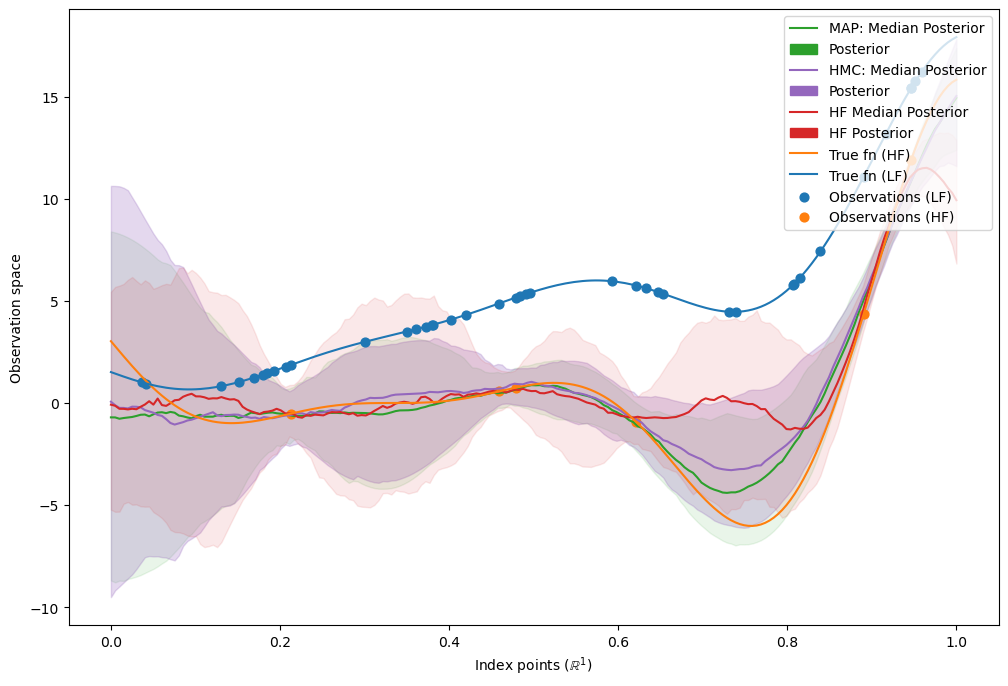

In [26]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 8))

# lower, median, upper = np.quantile(samples.numpy(), [0.25, 0.5, 0.75], axis=0)

# AR1: MAP
plt.plot(predictive_index_points_, median, c="C2", label="MAP: Median Posterior")
plt.fill_between(
    predictive_index_points_[:, 0],
    lower,
    upper,
    color="C2",
    alpha=0.1,
    label="Posterior",
)

hmc_lower, hmc_median, hmc_upper = np.quantile(
    hmc_samples.numpy(), [0.1, 0.5, 0.9], axis=0
)

# AR1: HMC
plt.plot(predictive_index_points_, hmc_median, c="C4", label="HMC: Median Posterior")
plt.fill_between(
    predictive_index_points_[:, 0],
    hmc_lower,
    hmc_upper,
    color="C4",
    alpha=0.25,
    label="Posterior",
)


lower_hf, median_hf, upper_hf = np.quantile(
    h_only_samples.numpy(), [0.1, 0.5, 0.9], axis=0
)

# HF
plt.plot(predictive_index_points_, median_hf, c="C3", label="HF Median Posterior")
plt.fill_between(
    predictive_index_points_[:, 0],
    lower_hf,
    upper_hf,
    color="C3",
    alpha=0.1,
    label="HF Posterior",
)

plt.plot(x_plot, y_plot_h, label="True fn (HF)", color="C1")
plt.plot(x_plot, y_plot_l, label="True fn (LF)", color="C0")

plt.scatter(x_train_l, y_train_l, color="C0", s=40, label="Observations (LF)")
plt.scatter(x_train_h, y_train_h, color="C1", s=40, label="Observations (HF)")


leg = plt.legend(loc="upper right")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()